<a href="https://colab.research.google.com/github/benvictoria21/python-machine-learning/blob/master/anomalydetection_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jupyterthemes

     |████████████████████████████████| 7.0MB 3.2MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 9.4MB 48.4MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
ERROR: google-colab 1.0.0 has requirement notebook~=5.3.0; python_version >= "3.0", but you'll have notebook 6.1.3 which is incompatible.
  Found existing installation: notebook 5.3.1
    Uninstalling notebook-5.3.1:
      Successfully uninstalled notebook-5.3.1


In [2]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv')
data.shape

(22695, 2)

In [4]:
data.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


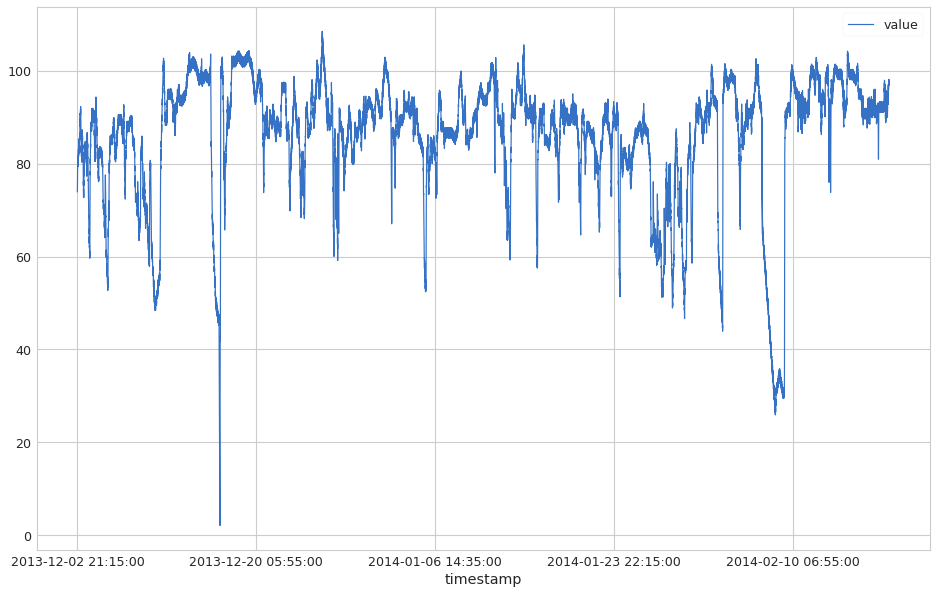

In [5]:
data.set_index('timestamp').plot(figsize=(16, 10))

In [6]:
from sklearn.model_selection import train_test_split

X = data['value'].values.reshape((len(data), 1))
y = data['value'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((20424, 1), (20424, 1), (2270, 1), (2270, 1))

In [7]:
X[1, :], y[0, :]

(array([74.935882]), array([74.935882]))

In [8]:
n_timesteps = 48
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]

In [9]:
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam

def Autoencoder(n_timesteps, n_features):
    i = Input(shape=(n_timesteps, n_features))
    
    x = LSTM(50, return_sequences=True)(i)
    x = Dropout(0.4)(x)
    
    x = LSTM(50)(x)
    x = Dropout(0.4)(x)

    x = Dense(n_features, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model

In [10]:
model = Autoencoder(n_timesteps, n_features)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 48, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 48, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                

In [11]:
model = Autoencoder(n_timesteps, n_features)
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=10, verbose=1,
                    callbacks=None, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/10
160/160 [==============================] - 1s 8ms/step - loss: 48.2426 - val_loss: 18.8448
Epoch 2/10
160/160 [==============================] - 1s 4ms/step - loss: 13.5794 - val_loss: 9.6237
Epoch 3/10
160/160 [==============================] - 1s 5ms/step - loss: 12.5590 - val_loss: 9.0042
Epoch 4/10
160/160 [==============================] - 1s 5ms/step - loss: 11.8613 - val_loss: 7.2170
Epoch 5/10
160/160 [==============================] - 1s 5ms/step - loss: 10.3193 - val_loss: 3.7437
Epoch 6/10
160/160 [==============================] - 1s 4ms/step - loss: 9.6003 - val_loss: 4.5340
Epoch 7/10
160/160 [==============================] - 1s 4ms/step - loss: 9.3404 - val_loss: 3.7167
Epoch 8/10
160/160 [==============================] - 1s 4ms/step - loss: 9.2848 - val_loss: 3.7859
Epoch 9/10
160/160 [==============================] - 1s 4ms/step - loss: 9.2384 - val_loss: 3.2896
Epoch 10/10
160/160 [==============================] - 1s 4ms/step - loss: 9.0398 - val_loss: 

In [12]:
y_train_pred = model.predict(X_train)
y_train_pred.shape

(20424, 1)

In [13]:
from sklearn.metrics import mean_absolute_error
errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
len(errors)

20424

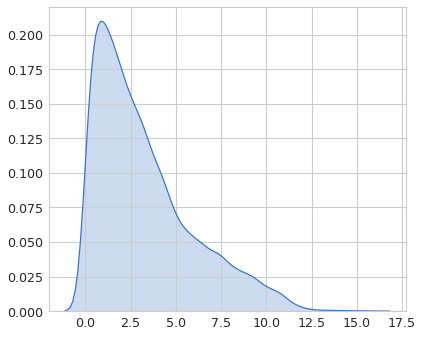

In [14]:
import seaborn as sb
sb.kdeplot(errors, shade=True)

In [15]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(3.2579784260651863, 2.6684368223461203)

In [16]:
def is_anomaly(error, mean, std, threshold):
    delta = np.abs(error - mean)
    multiple = delta / std
    if multiple < threshold:
        return 0
    else:
        return 1

In [18]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)